In [32]:
import numpy as np
import random
from math import sqrt
import gurobipy as gp
import networkx as nx 
import torch
import matplotlib.pyplot as plt

In [60]:
def bernoulli(p):
    if random.random() <= p:
        return 1
    else:
        return 0

def generate_poly_kernel_data(B_true, n, degree, inner_constant=1, outer_constant=1, kernel_damp_normalize=True, 
                              kernel_damp_factor=1, noise=True, noise_half_width=0, normalize_c=True, normalize_small_threshold = 0.0001):
    """
        generate_poly_kernel_data(B_true, n, degree; inner_constant=1, outer_constant = 1, kernel_damp_normalize=true,
            kernel_damp_factor=1, noise=true, noise_half_width=0, normalize_c=true)

    Generate (X, c) from the polynomial kernel model X_{ji} ~ N(0, 1) and
    c_i(j) = ( (alpha_j * B_true[j,:] * X[:,i]  + inner_constant)^degree + outer_constant ) * epsilon_{ij} where
    alpha_j is a damping term and epsilon_{ij} is a noise term.

    # Arguments
    - `kernel_damp_normalize`: if true, then set
    alpha_j = kernel_damp_factor/norm(B_true[j,:]). This results in
    (alpha_j * B_true[j,:] * X[:,i]  + inner_constant) being normally distributed with
    mean inner_constant and standard deviation kernel_damp_factor.
    - `noise`:  if true, generate epsilon_{ij} ~  Uniform[1 - noise_half_width, 1 + noise_half_width]
    - `normalize_c`:  if true, normalize c at the end of everything
    """
    d, p = B_true.shape
    X_observed = np.random.normal(0, 1, (p, n))
    dot_prods = np.matmul(B_true, X_observed)

    # first generate c_observed without noise
    c_observed = np.zeros((d, n))
    for i in range(d):
        if kernel_damp_normalize:
            cur_kernel_damp_factor = kernel_damp_factor/np.linalg.norm(B_true[i,:])
        else:
            cur_kernel_damp_factor = kernel_damp_factor
        for j in range(n):
            c_observed[i, j] = (cur_kernel_damp_factor*dot_prods[i, j] + inner_constant)**degree + outer_constant
            if noise:
                epsilon = (1 - noise_half_width) + 2*noise_half_width*random.random()
                c_observed[i, j] *= epsilon
    if normalize_c:
        c_observed[:, i] = c_observed[:, i]/np.linalg.norm(c_observed[:, i])
        for j in range(d):
            if abs(c_observed[j, i]) < normalize_small_threshold:
                c_observed[j, i] = 0
    return X_observed, c_observed

def generate_poly_kernel_data_simple(B_true, n, polykernel_degree, noise_half_width):
    d, p = B_true.shape
    alpha_factor = 1/sqrt(p)
    if noise_half_width == 0:
        noise_on = False
    else:
        noise_on = True
    return generate_poly_kernel_data(B_true, n, polykernel_degree,
        kernel_damp_factor = alpha_factor,
		noise = noise_on, noise_half_width = noise_half_width,
        kernel_damp_normalize = False,
        normalize_c = False,
		inner_constant = 3)

def batch_solve(solver, y, relaxation =False):
    sol = []
    value = []
    y = np.transpose(y)
    for i in range(len(y)):
        sol.append(solver.solve(y[i], relaxation=relaxation)[0])
        value.append(solver.solve(y[i], relaxation=relaxation)[1])
    return np.transpose(np.array(sol)), np.transpose(np.array(value).reshape(-1, 1))

# Create and show the graph
def define_graph(grid_width, showflag=False):
    V = range(grid_width**2)
    E = []

    for i in V:
        if (i+1)%grid_width !=0:
            E.append((i,i+1))
        if i+grid_width<grid_width**2:
                E.append((i,i+grid_width))

    G = nx.DiGraph()
    G.add_nodes_from(V) # from point 1 to point 3
    G.add_edges_from(E)
    nx.draw_networkx(G)
    if showflag:
        plt.show()
    return G

class Shortest_path_solver:
    def __init__(self, G):
        self.G = G
    
    def make_model(self, relaxation=False):
        A = nx.incidence_matrix(self.G, oriented=True).todense() # Return a dense matrix representation of SciPy sparse matrix.
        b =  np.zeros(len(A))
        b[0] = -1
        b[-1] =1
        model = gp.Model()
        model.setParam('OutputFlag', 0)
        vtype = gp.GRB.CONTINUOUS if relaxation else gp.GRB.BINARY
        x = model.addMVar(shape=A.shape[1], name="x", vtype= vtype)
        model.addConstr(A @ x == b, name="eq")
        self.model, self.x =  model, x

    def obj_expr(self, y, x):
        return gp.quicksum(y@x)  # Sum

    def solve(self, y, relaxation=False):
        self.make_model(relaxation=relaxation)
        self.model.setObjective(y@ self.x, gp.GRB.MINIMIZE)
        self.model.optimize()
        return [self.x.x, self.model.objVal]
# def oracle_dataset(c, oracle):
#     """
#     Apply the optimization oracle to each column of the d x n matrix c, return
#     an n vector of z_star values and a d x n matrix of optimal solutions
#     """
#     d, n = c.shape
#     z_star = np.zeros(n)
#     x_star = np.zeros((d, n))
#     for i in range(n):
#         x_star[:, i], z_star[i] = oracle(c[:, i])
#     return z_star, x_star

# def convert_grid_to_list(dim1, dim2):
#     G = nx.grid_2d_graph(dim1, dim2)
#     sources = []
#     destinations = []
#     for edge in G.edges():
#         sources.append(edge[0])
#         destinations.append(edge[1])
#     return sources, destinations




C:\Users\zhaoz\AppData\Local\Temp\ipykernel_35040\2251156556.py:95: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(self.G, oriented=True).todense() # Return a dense matrix representation of SciPy sparse matrix.


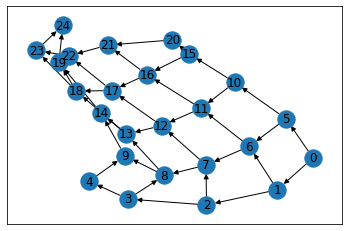

In [61]:
# def shortest_path_replication(grid_dim,
#     n_train, n_holdout, n_test,
#     p_features, polykernel_degree, polykernel_noise_half_width,
#     num_lambda = 10, lambda_max = None, lambda_min_ratio = 0.0001, regularization = 'ridge',
#     different_validation_losses = False,
#     include_rf = True):
different_validation_losses = False
n_holdout = 1000
n_test = 1000
grid_dim = 5
# Get oracle
# sources, destinations = convert_grid_to_list(grid_dim, grid_dim)
# d_feasibleregion = len(sources)
# sp_oracle = sp_flow_jump_setup(sources, destinations, 1, grid_dim^2; gurobiEnv = gurobiEnvOracle)
# sp_graph = shortest_path_graph(sources = sources, destinations = destinations,
#     start_node = 1, end_node = grid_dim^2, acyclic = True)
p_features = 5
n_train = 1000
polykernel_degree = 1
polykernel_noise_half_width = 0
d_feasibleregion = 2 * p_features * (p_features - 1)
B_true = np.array([[bernoulli(0.5) for k in range(p_features)] for e in range(d_feasibleregion)])
X_train, c_train = generate_poly_kernel_data_simple(B_true, n_train, polykernel_degree, polykernel_noise_half_width)
X_validation, c_validation = generate_poly_kernel_data_simple(B_true, n_holdout, polykernel_degree, polykernel_noise_half_width)
X_test, c_test = generate_poly_kernel_data_simple(B_true, n_test, polykernel_degree, polykernel_noise_half_width)
# Add intercept in the first row of X
# an intercept term is a constant term that is added to a linear model to 
# account for the mean or baseline level of the target variable.
X_train = np.vstack((np.ones(n_train), X_train))
X_validation = np.vstack((np.ones(n_holdout), X_validation))
X_test = np.vstack((np.ones(n_test), X_test))

# Solve the shortest path problem
G = define_graph(grid_dim, showflag=False)
solver = Shortest_path_solver(G)
z_train, w_train = batch_solve(solver, c_train)
z_validation, w_validation = batch_solve(solver, c_validation)
z_test, w_test = batch_solve(solver, c_test)

c_ham_train = np.ones((d_feasibleregion, n_train)) - w_train
c_ham_validation = np.ones((d_feasibleregion, n_holdout)) - w_validation
c_ham_test = np.ones((d_feasibleregion, n_test)) - w_test

# Put train + validation together
X_both = np.hstack((X_train, X_validation))
c_both = np.hstack((c_train, c_validation))
c_ham_both = np.hstack((c_ham_train, c_ham_validation))
train_index = np.arange(n_train)
validation_index = np.arange(n_train, n_train + n_holdout)

# Set validation losses
if different_validation_losses:
    spo_plus_val_loss = 'spo_loss'
    ls_val_loss = 'least_squares_loss'
    ssvm_val_loss = 'hamming_loss'
    absolute_val_loss = 'absolute_loss'
    huber_val_loss = 'huber_loss'
else:
    spo_plus_val_loss = 'spo_loss'
    ls_val_loss = 'spo_loss'
    ssvm_val_loss = 'spo_loss'
    absolute_val_loss = 'spo_loss'
    huber_val_loss = 'spo_loss'